
Exploratory Data Analysis


# **Images and Annotations**

Ali Zolfagharian








**Libraries**

In [1]:
import numpy as np
import pandas as pd
import json
import gcsfs
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage


**Connecting to data in google cloud bucket and retrieving dataframes**
- loading nutrition csv
- annotation json file
- retrieving dataframes: 
    - categories
    - images 
    - annotations 
    - nutrition

In [29]:
jsonSeries = pd.read_json('gs://foodygs/foodyai_data/Training_2/annotations.json',typ='series')
# jsonseries has three dataframe and it could be retrieved as the following

categories = pd.DataFrame(jsonSeries.categories)  
images = pd.DataFrame(jsonSeries.images)
annotations = pd.DataFrame(jsonSeries.annotations)

In [14]:
nutrition = pd.read_csv('gs://foodygs/Nutrition/nutrition.csv', sep=",", index_col=0)

Let's take a look at the dataframes that we have from json and csv files that we read


In [30]:
categories.head(2)

,id,name,name_readable,supercategory
0,50,beetroot-steamed-without-addition-of-salt,"Beetroot, steamed, without addition of salt",food
1,101246,bread_wholemeal,bread_wholemeal,food


In [31]:
images.head(2)

,id,file_name,width,height
0,131072,131072.jpg,464,464
1,131087,131087.jpg,464,464


In [32]:
annotations.head(2)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,184123,131072,101246,"[[169.0, 379.5, 130.0, 374.5, 112.0, 363.5, 94...",71393.0,"[61.5, 61.5, 318.0, 322.0]",0
1,184983,131072,100546,"[[354.82462890625004, 122.45733215332031, 235....",57608.0,"[93.82462890625001, 93.82462890625001, 274.552...",0


In [33]:
nutrition.head(2)

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g


Here some observations to see whether we could get nutrition with name



<AxesSubplot: >

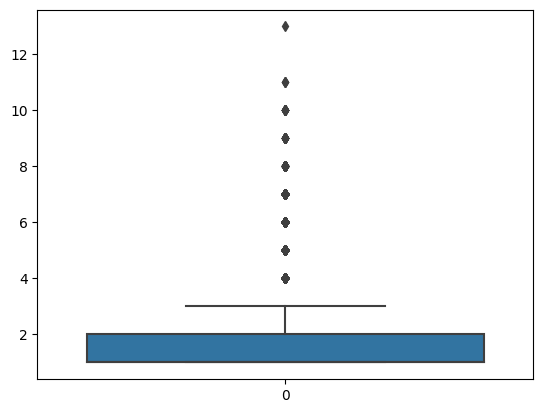

In [65]:
annotaion_grouped = annotations.groupby('image_id').agg({'category_id':'nunique'}).reset_index()
sns.boxplot(annotaion_grouped['category_id'])

In [58]:
def compare(str1='egg,carrot,butter',str2='butter,bread_whole.cake-salad'):
  
  ''' this function compare two string and 
  return ratio of number of common words to length of both string together
  should not be interpreted as probabilities '''
  
  strarr1 = str1.lower().replace('-',',').replace('_',',').replace('.',',').split(',')
  strarr2 = str2.lower().replace('-',',').replace('_',',').replace('.',',').split(',')
  similarities = 0
  for name in strarr1:
      if name in strarr2:
        similarities+=1
  return similarities/(len(strarr1)+len(strarr2))
print(f'result of (egg,carrot,butter) and (butter,bread_whole.cake-salad) is {compare()}')

result of (egg,carrot,butter) and (butter,bread_whole.cake-salad) is 0.125


Let's try to see whether we could find colsest names in nutrition dataframe according to a long name of a category:
- category: 'Beetroot, steamed, without addition of salt'


In [80]:
a_name = categories[categories['id']==50]['name_readable']
a_name, type(str(a_name))

(0    Beetroot, steamed, without addition of salt
 Name: name_readable, dtype: object,
 str)

In [95]:
def category_nutrition(a_cat,df):
    #receiving a category and a dataframe with column name, and returning sorted by similarity of columns name
    nutri = df.copy()
    nutri['val'] = [compare(a_name,a) for a in list(nutrition['name'])]
    return nutri.sort_values(by='val',ascending=False)[['name','val']]

a_name = str(categories[categories['id']==50]['name_readable'])
print(f'similar to {a_name}, in dataframe has been sorted as follow')
category_nutrition(a_name,nutrition).head(2)


similar to 0    Beetroot, steamed, without addition of salt
Name: name_readable, dtype: object, in dataframe has been sorted as follow


,name,val
4473,"Sweet potato leaves, without salt, steamed, co...",0.111111
3800,"Sesbania flower, without salt, steamed, cooked",0.111111


clearly it is very difficult and we need better function



---


**Now we could focus on images and annotations dataframes**










In [16]:
images.head()

,id,file_name,width,height
0,131094,131094.jpg,480,480
1,131097,131097.jpg,391,390
2,131098,131098.jpg,391,390
3,131100,131100.jpg,391,390
4,131101,131101.jpg,391,390


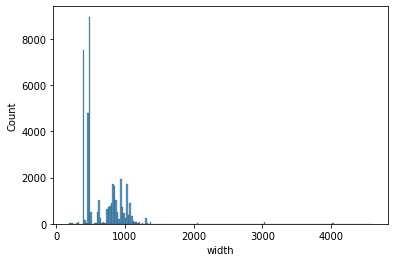

In [17]:
sns.histplot(images['width'])

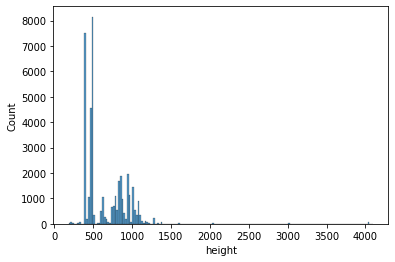

In [18]:
sns.histplot(images['height'])

In [19]:
images.describe()

,id,width,height
count,39962.000000,39962.000000,39962.000000
mean,90858.920900,650.675792,652.695010
std,51044.060525,287.916148,295.307311
min,6316.000000,182.000000,183.000000
25%,46291.250000,464.000000,464.000000
50%,87042.000000,480.000000,480.000000
75%,136441.000000,853.000000,853.000000
max,185902.000000,4608.000000,4096.000000


[min, max] width and height of images are:

- width :  [182,4608] 
- height : [183,4096] 


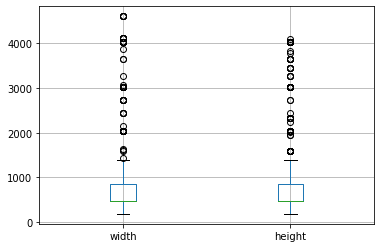

In [20]:
images[['width','height']].boxplot()

In [21]:
len(images[images['width']>1500]),len(images[images['height']>1500])

(156, 174)

we have less than 200 images that their size is very large and could be considered as outliers


---


**Annotations Dataframe**

In [96]:
annotations.head(3)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,184123,131072,101246,"[[169.0, 379.5, 130.0, 374.5, 112.0, 363.5, 94...",71393.0,"[61.5, 61.5, 318.0, 322.0]",0
1,184983,131072,100546,"[[354.82462890625004, 122.45733215332031, 235....",57608.0,"[93.82462890625001, 93.82462890625001, 274.552...",0
2,184129,131087,101129,"[[296.82462890625, 129.41734985351562, 106.584...",68720.0,"[62.50462890625, 62.50462890625, 347.632720947...",0


bbox is a rectangle arr of four elements and segmentation is the area of an object

In [62]:
annotaion_grouped = annotations.groupby('image_id').agg({'category_id':'nunique'}).reset_index()

In [97]:
annotaion_grouped.head(3)

,image_id,category_id
0,6316,1
1,6331,1
2,6335,3


Now we could check how many categories get every images. A boxplot tells us better

<AxesSubplot: >

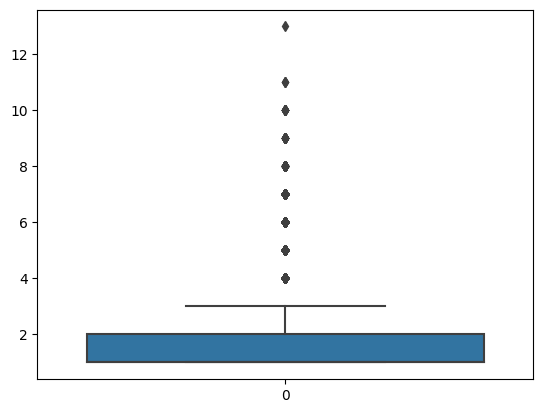

In [110]:
sns.boxplot(annotaion_grouped['category_id'])

In [116]:
print(f"ratio of more than 3 category id for a food is {len(annotaion_grouped[annotaion_grouped['category_id']>3])/len(annotaion_grouped['category_id'])}")

ratio of more than 3 category id for a food is 0.08661200176496543


In [117]:
images.head()

,id,file_name,width,height
0,131072,131072.jpg,464,464
1,131087,131087.jpg,464,464
2,131088,131088.jpg,511,512
3,131094,131094.jpg,480,480
4,131096,131096.jpg,464,464


(-0.5, 1023.5, 1023.5, -0.5)

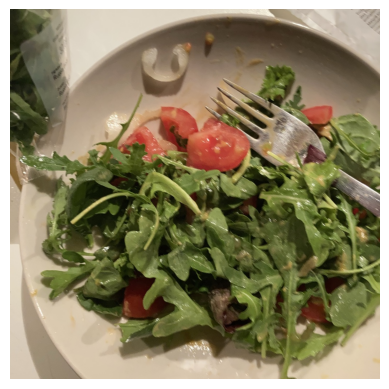

In [148]:

plt.imshow(plt.imread('img/185770.jpg'))
plt.axis('off')


In [149]:
annotations[annotations['image_id']==185770]

,id,image_id,category_id,segmentation,area,bbox,iscrowd
63081,324941,185770,100089,"[[928.0, 281.6, 789.76, 296.96, 833.28, 340.48...",78361.0,"[280.32, 280.32, 647.6800000000001, 647.680000...",0
63082,325763,185770,101209,"[[697.6, 186.88, 718.08, 284.16, 710.4, 440.32...",498971.0,"[37.12, 37.12, 899.84, 960.0]",0


In [189]:
def plot_segmentation(m,anno):
    xy = anno[m]
    i=0
    x=[]
    y=[]
    for a in xy:
       if i%2==0:
          x.append(a)  
       else:
          y.append(a)
       i+=1
    
    return [x,y]

In [190]:
xy=[]
for m in range(len(annotations[annotations['image_id']==185770]['segmentation'][63081])):
    xy.append(plot_segmentation(m,annotations[annotations['image_id']==185770]['segmentation'][63081]))


In [191]:
xy[0]


[[928.0, 789.76, 833.28, 910.08, 922.88],
 [281.6, 296.96, 340.48, 299.52, 271.36]]

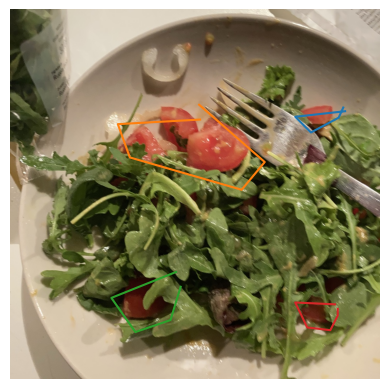

In [192]:
plt.imshow(plt.imread('img/185770.jpg'))
plt.axis('off')
plt.plot(xy[0][0],xy[0][1])
plt.plot(xy[1][0],xy[1][1])
plt.plot(xy[2][0],xy[2][1])
plt.plot(xy[3][0],xy[3][1])
plt.show()

In [193]:
xy=[]
for m in range(len(annotations[annotations['image_id']==185770]['segmentation'][63082])):
    xy.append(plot_segmentation(m,annotations[annotations['image_id']==185770]['segmentation'][63082]))


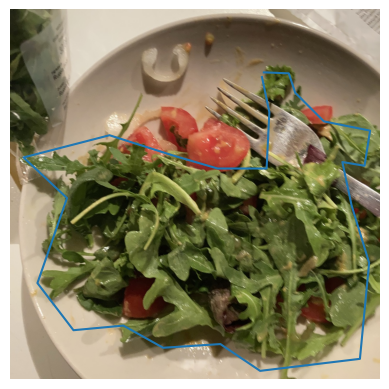

In [196]:
plt.imshow(plt.imread('img/185770.jpg'))
plt.axis('off')
plt.plot(xy[0][0],xy[0][1])

plt.show()

In [197]:
pwd

'/home/ali/code/w0shitim/foodyai/notebooks'

do we have image for all categories

In [201]:
categories.head(2)

,id,name,name_readable,supercategory
0,50,beetroot-steamed-without-addition-of-salt,"Beetroot, steamed, without addition of salt",food
1,101246,bread_wholemeal,bread_wholemeal,food


In [203]:
images.head(2)

,id,file_name,width,height
0,131072,131072.jpg,464,464
1,131087,131087.jpg,464,464


In [207]:
annotations.head(2)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,184123,131072,101246,"[[169.0, 379.5, 130.0, 374.5, 112.0, 363.5, 94...",71393.0,"[61.5, 61.5, 318.0, 322.0]",0
1,184983,131072,100546,"[[354.82462890625004, 122.45733215332031, 235....",57608.0,"[93.82462890625001, 93.82462890625001, 274.552...",0


In [208]:
nutrition.head(2)

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g


In [228]:
category_image = annotations.groupby('category_id').agg({'image_id':'count'}).reset_index()

In [229]:
category_image[category_image['image_id']==1]

,category_id,image_id


In [230]:
category_image.columns

Index(['category_id', 'image_id'], dtype='object')

In [237]:
category_image[category_image['image_id']>10000]

,category_id,image_id


<AxesSubplot: xlabel='image_id', ylabel='Count'>

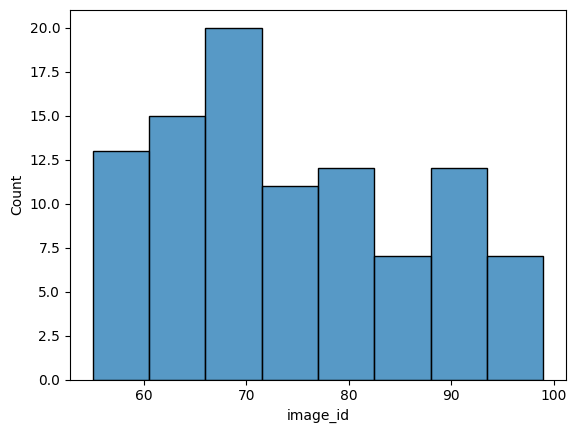

In [246]:
sns.histplot(category_image[category_image['image_id']<100]['image_id'])

<AxesSubplot: >

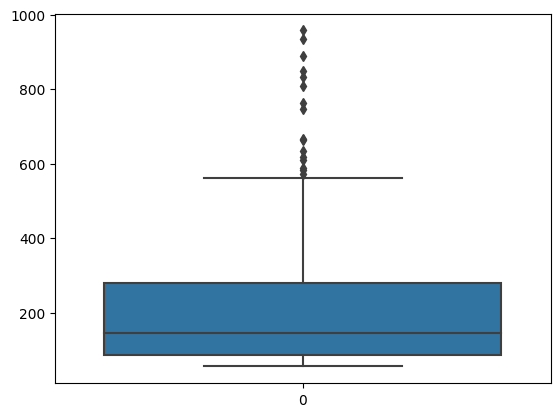

In [248]:
sns.boxplot(category_image[category_image['image_id']<1000]['image_id'])

In [254]:
print (f"minimum and maximum number of images per category are respectively: {category_image['image_id'].min()},{category_image['image_id'].max()}")

minimum and maximum number of images per category are respectively: 55,6970


We have at least 55 images per a category, and it seems enough training data. However generating more training material by image augmentation might be help full as well

In [255]:
category_image['image_id'].mean()

310.39009287925694